#機器學習專案
* 使用資料處理專案內的資料集來進行預測
* 資料集 : https://drive.google.com/file/d/1jLY9tDrXInR0q98MO5qvCURFB5PnLeD6/view?usp=sharing

安裝所需套件

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from scipy.stats import wilcoxon
from statsmodels.stats import multitest
import rpy2.robjects as robj
r = robj.r
from rpy2.robjects.packages import importr

從之前整理好合併的檔案中，還原成訓練及測試資料

In [13]:
all_data = pd.read_csv('all_data.csv')
train_data = all_data.loc[all_data["Survived"].notnull()]  # loc是透過布林值來判斷
test_data = all_data.loc[all_data["Survived"].isnull()]

train = pd.DataFrame(train_data)
train = train.drop(columns=["Name","Ticket","index","PassengerId"])

test = pd.DataFrame(test_data)
test = test.drop(columns=["Name","Ticket","index","PassengerId"])

將資料標準化

In [14]:
selected_columns=["Age", "Fare"]
sc = StandardScaler()
train[selected_columns] = sc.fit_transform(train[selected_columns])
test[selected_columns] = sc.fit_transform(test[selected_columns])
print(train.shape,test.shape)

(891, 8) (418, 8)


資料切片取欄位

In [15]:
x = train.iloc[:, 1:6].values
y = train.iloc[:, 0].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

## 建立模型及預測
# 模型 :
* 羅吉斯回歸
* K-近鄰演算法
* 支援向量機(線性)
* 支援向量機(徑向基函數)
* 貝氏分類器(GaussianNB)
* 貝氏分類器(BernoulliNB)
* 決策樹
* 隨機森林

# 步驟 :
1. 設定分類器
2. 訓練模型
3. 計算訓練及測試的準確性
4. 提取陽性樣本，透過陽性樣本計算AUC
5. 構圖觀察特徵重要性
6. 統計檢定比較預測能力


In [16]:
def models(xtrain, ytrain, xtest, ytest):
    # 羅吉斯回歸
    LR = LogisticRegression(random_state=1)
    LR.fit(xtrain, ytrain)
    LR_train_accuracy = LR.score(xtrain, ytrain)
    LR_test_accuracy = LR.score(xtest, ytest)
    LR_probs = LR.predict_proba(xtest)[:, 1]
    LR_test_auc = roc_auc_score(ytest, LR_probs)

    # KNeighbors
    KNN = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
    KNN.fit(xtrain, ytrain)
    KNN_train_accuracy = KNN.score(xtrain, ytrain)
    KNN_test_accuracy = KNN.score(xtest, ytest)
    KNN_probs = KNN.predict_proba(xtest)[:, 1]
    KNN_test_auc = roc_auc_score(ytest, KNN_probs)

    # SVC(Linear)
    svc_lin = SVC(kernel='linear', random_state=0, probability=True)
    svc_lin.fit(xtrain, ytrain)
    svc_lin_train_accuracy = svc_lin.score(xtrain, ytrain)
    svc_lin_test_accuracy = svc_lin.score(xtest, ytest)
    svc_lin_probs = svc_lin.predict_proba(xtest)[:, 1]
    svc_lin_test_auc = roc_auc_score(ytest, svc_lin_probs)

    # SVC(RBF kernal)
    svc_rbf = SVC(kernel='rbf', random_state=0, probability=True)
    svc_rbf.fit(xtrain, ytrain)
    svc_rbf_train_accuracy = svc_rbf.score(xtrain, ytrain)
    svc_rbf_test_accuracy = svc_rbf.score(xtest, ytest)
    svc_rbf_probs = svc_rbf.predict_proba(xtest)[:, 1]
    svc_rbf_test_auc = roc_auc_score(ytest, svc_rbf_probs)

    # GaussianNB
    gauss = GaussianNB()
    gauss.fit(xtrain, ytrain)
    gauss_train_accuracy = gauss.score(xtrain, ytrain)
    gauss_test_accuracy = gauss.score(xtest, ytest)
    gauss_probs = gauss.predict_proba(xtest)[:, 1]
    gauss_test_auc = roc_auc_score(ytest, gauss_probs)

    # BernoulliNB
    BNB = BernoulliNB(binarize=1)
    BNB.fit(xtrain, ytrain)
    BNB_train_accuracy = BNB.score(xtrain, ytrain)
    BNB_test_accuracy = BNB.score(xtest, ytest)
    BNB_probs = BNB.predict_proba(xtest)[:, 1]
    BNB_test_auc = roc_auc_score(ytest, BNB_probs)

    # DecisionTree
    tree = DecisionTreeClassifier(criterion='entropy', random_state=0)
    tree.fit(xtrain, ytrain)
    tree_train_accuracy = tree.score(xtrain, ytrain)
    tree_test_accuracy = tree.score(xtest, ytest)
    tree_probs = tree.predict_proba(xtest)[:, 1]
    tree_test_auc = roc_auc_score(ytest, tree_probs)

    # RandomForest
    RF = RandomForestClassifier(n_estimators=200, criterion='gini', random_state=1)
    RF.fit(xtrain, ytrain)
    RF_train_accuracy = RF.score(xtrain, ytrain)
    RF_test_accuracy = RF.score(xtest, ytest)
    RF_probs = RF.predict_proba(xtest)[:, 1]
    RF_test_auc = roc_auc_score(ytest, RF_probs)

    # Adaboost
    adaboost = AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=1)
    adaboost.fit(xtrain, ytrain)
    adaboost_train_accuracy = adaboost.score(xtrain, ytrain)
    adaboost_test_accuracy = adaboost.score(xtest, ytest)
    adaboost_probs = adaboost.predict_proba(xtest)[:, 1]
    adaboost_test_auc = roc_auc_score(ytest, adaboost_probs)

    accuracies = {
        'Logistic Regression Train Accuracy': LR_train_accuracy,
        'Logistic Regression Test Accuracy': LR_test_accuracy,
        'Logistic Regression AUC': LR_test_auc,

        'K Neighbors Train Accuracy': KNN_train_accuracy,
        'K Neighbors Test Accuracy': KNN_test_accuracy,
        'K Neighbors Test AUC': KNN_test_auc,

        'SVC(Linear) Train Accuracy': svc_lin_train_accuracy,
        'SVC(Linear) Test Accuracy': svc_lin_test_accuracy,
        'SVC(Linear) Test AUC': svc_lin_test_auc,

        'SVC(RBF) Train Accuracy': svc_rbf_train_accuracy,
        'SVC(RBF) Test Accuracy': svc_rbf_test_accuracy,
        'SVC(RBF) Test AUC': svc_rbf_test_auc,

        'GaussianNB Train Accuracy': gauss_train_accuracy,
        'GaussianNB Test Accuracy': gauss_test_accuracy,
        'GaussianNB Test AUC': gauss_test_auc,

        'BernoulliNB Train Accuracy': BNB_train_accuracy,
        'BernoulliNB Test Accuracy': BNB_test_accuracy,
        'BernoulliNB Test AUC': BNB_test_auc,

        'DecisionTree Train Accuracy': tree_train_accuracy,
        'DecisionTree Test Accuracy': tree_test_accuracy,
        'DecisionTree Test AUC': tree_test_auc,

        'RandomForest Train Accuracy': RF_train_accuracy,
        'RandomForest Test Accuracy': RF_test_accuracy,
        'RandomForest Test AUC': RF_test_auc,

        'Adaboosting Train Accuracy': adaboost_train_accuracy,
        'Adaboosting Test Accuracy': adaboost_test_accuracy,
        'Adaboosting Test AUC': adaboost_test_auc
    }
    return accuracies

In [ ]:
models(x_train, y_train, x_test, y_test)
# AUC前三名最高的依序是RandomForest,K-NN,Logistic

{'Logistic Regression Train Accuracy': 0.797752808988764,
 'Logistic Regression Test Accuracy': 0.7821229050279329,
 'Logistic Regression AUC': 0.8231455156371154,
 'K Neighbors Train Accuracy': 0.8567415730337079,
 'K Neighbors Test Accuracy': 0.7541899441340782,
 'K Neighbors Test AUC': 0.8391703282501939,
 'SVC(Linear) Train Accuracy': 0.7893258426966292,
 'SVC(Linear) Test Accuracy': 0.776536312849162,
 'SVC(Linear) Test AUC': 0.8086714913414317,
 'SVC(RBF) Train Accuracy': 0.8230337078651685,
 'SVC(RBF) Test Accuracy': 0.7932960893854749,
 'SVC(RBF) Test AUC': 0.8066037735849056,
 'GaussianNB Train Accuracy': 0.7949438202247191,
 'GaussianNB Test Accuracy': 0.7430167597765364,
 'GaussianNB Test AUC': 0.8129361592142672,
 'BernoulliNB Train Accuracy': 0.6839887640449438,
 'BernoulliNB Test Accuracy': 0.659217877094972,
 'BernoulliNB Test AUC': 0.6676143706384079,
 'DecisionTree Train Accuracy': 0.9845505617977528,
 'DecisionTree Test Accuracy': 0.7541899441340782,
 'DecisionTree Te

#構圖觀察各種預測方法的準確度及AUC

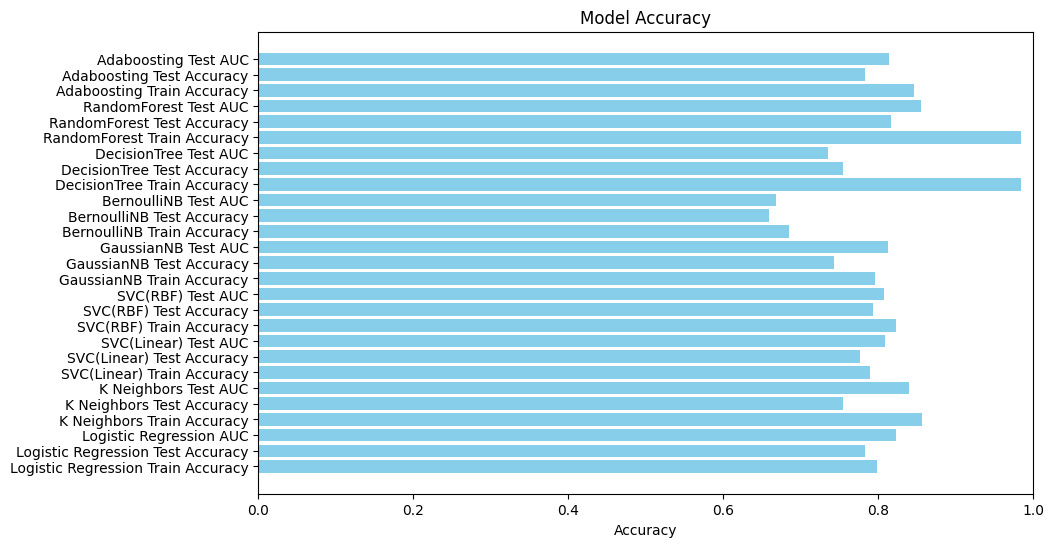

In [17]:
result = models(x_train, y_train, x_test, y_test)
df = pd.DataFrame.from_dict(result, orient='index', columns=['Accuracy'])
plt.figure(figsize=(10, 6))
plt.barh(df.index, df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy')
plt.xlim(0, 1)  # x軸的範圍從0到1
plt.show()

#構圖觀察(以AUC最高的隨機林為例)

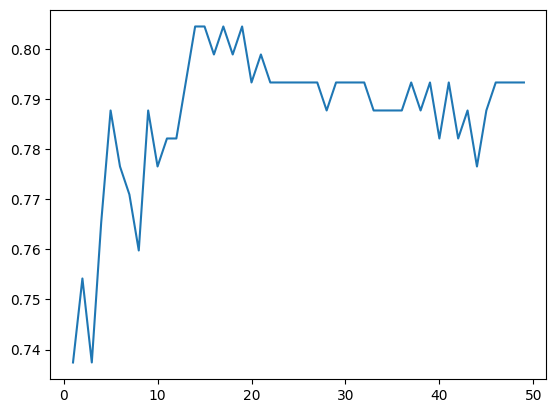

In [18]:
accuracy = []
for k in range(1,50):
  RF = RandomForestClassifier(n_estimators=k, criterion='gini', random_state=1)
  RF.fit(x_train, y_train)
  y_pred = RF.predict(x_test)
  accuracy.append(metrics.accuracy_score(y_test, y_pred))
k_range = range(1,50)
plt.plot(k_range, accuracy)
plt.show()

#構表觀察特徵重要性

In [19]:
selected_model = RandomForestClassifier(n_estimators=200, criterion='gini', random_state=1)
selected_model.fit(x_train, y_train)
importances = pd.DataFrame({'feature': train.iloc[:, 1:6].columns, 'importance': np.round(selected_model.feature_importances_, 4)} )
importances = importances.sort_values('importance', ascending = False).set_index('feature')
importances
# 特徵重要性最高的前三依序為票價、年齡、性別
# 如果要預測一個人能不能在船難中生存，可以優先取用票價、年紀、性別等特徵來進行預測
# 而船艙等級、家庭成員數、登船港口，對於預測上的實質幫助並不多

,importance
feature,
Fare,0.3003
Age,0.2881
Sex,0.2732
Pclass,0.1052
Embarked,0.0331


#Delong Test檢定看看預測效果是否有顯著差異
* 比較AUC最高的前兩個分類器(隨機森林、KNN)
* 引用網站 : https://www.jianshu.com/p/a95a161e6e99

In [34]:
KNN = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
KNN.fit(x_train, y_train)
KNN_pred =  KNN.predict(x_test)

RF = RandomForestClassifier(n_estimators=200, criterion='gini', random_state=1)
RF.fit(x_train, y_train)
RF_pred =  RF.predict(x_test)

In [35]:
import rpy2.robjects as robj
r = robj.r
from rpy2.robjects.packages import importr

def roc_test_r(targets_1, scores_1, targets_2, scores_2, method='delong'):
    # method: “delong”, “bootstrap” or “venkatraman”
    importr('pROC')
    robj.globalenv['targets_1'] = targets_1 = robj.FloatVector(targets_1)
    robj.globalenv['scores_1'] = scores_1 = robj.FloatVector(scores_1)
    robj.globalenv['targets_2'] = targets_2 = robj.FloatVector(targets_2)
    robj.globalenv['scores_2'] = scores_2 = robj.FloatVector(scores_2)

    r('roc_1 <- roc(targets_1, scores_1)')
    r('roc_2 <- roc(targets_2, scores_2)')
    r('result = roc.test(roc_1, roc_2, method="%s")' % method)
    p_value = r('p_value = result$p.value')
    return np.array(p_value)[0]

roc_test_r(y_test, KNN_pred, y_test, RF_pred, method='delong')

0.028332832120551706

# 小結 : 在顯著水準0.05下，有足夠證據推翻虛無假設，表示兩分類器之預測能力有顯著差異